In [1]:
import sys
sys.path.append("clustering")

from utils import get_data_dir

In [2]:
import os
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
import numpy as np

class DocumentClassifier:
    def __init__(self, data_dir: str, model):
        self.data_dir = data_dir
        self.model = model
        self.label_sets = {}
        self.abstracts = {}
        self.vectorizer = None
        self.df = None
        self.test_df = None
        self.X_train = None
        self.X_test = None
        self.label_to_method = {'kmeans_label': 'Periodical2Vec+$k$-means',
                                 'skm_label': 'Periodical2Vec+Sperical $k$-means',
                                 'movmf_label': 'Periodical2Vec+movMF',
                                 
                                 'bert_kmeans_label': 'BERT+$k$-means',
                                 'n2v_kmeans_label': 'Node2Vec+$k$-means',
                                 'cm_kmeans_label': 'Citation Matrix+$k$-means',
                                 'gnn_kmeans_label': 'GNN+$k$-means',
                                 'scopus_label': 'Scopus'
                                 }
        self.n_splits = 10

    def load_data(self) -> None:
        """加载abstracts和所有标签集"""
        # 加载abstracts - 处理JSON Lines格式
        abstracts_path = os.path.join(self.data_dir, '2010s/classification_tasks/abstracts/paper_abstracts.json')
        print("Loading abstracts...")
        with open(abstracts_path, 'r') as f:
            for line in tqdm(f):
                try:
                    paper_data = json.loads(line.strip())
                    # 直接获取PaperID和abstract
                    pid = str(paper_data['PaperID'])  # 确保ID是字符串
                    self.abstracts[pid] = paper_data['abstract']
                except (json.JSONDecodeError, KeyError) as e:
                    continue
        print(f"Loaded {len(self.abstracts)} abstracts")

        # 加载所有标签文件
        labels_dir = os.path.join(self.data_dir, '2010s/classification_tasks/labels')
        for label_file in os.listdir(labels_dir):
            if label_file.endswith('.json'):
                label_name = label_file.replace('.json', '')
                with open(os.path.join(labels_dir, label_file), 'r') as f:
                    self.label_sets[label_name] = json.load(f)
    
    def prepare_dataset(self):
        """为所有种类的标签准备训练数据集"""
        print('Preparing dataset...')
        print('label types: ', self.label_sets.keys())
        # 构建数据集
        data = []
        # 遍历所有论文
        for paper_id, abstract in self.abstracts.items():
            # 为每篇论文创建一个基础行
            row = {
                'PaperID': paper_id,
                'abstract': abstract
            }
            # 添加所有类型的标签
            for label_type in self.label_sets.keys():
                # 如果论文在该标签集中存在，添加标签值；否则设为None
                row[label_type] = self.label_sets[label_type].get(paper_id)
            
            data.append(row)
        
        self.df = pd.DataFrame(data)
        self.df = self.df.dropna(subset=self.label_sets.keys(), how='any')
        print(f"Prepared dataset with {len(self.df)} samples")

    def train_model(self, label_name: str):
        """训练特定标签的分类模型"""
        if self.df is None:
            print("Dataset not found, preparing dataset...")
            self.prepare_dataset()
        # 准备数据集
        train_df, test_df = train_test_split(self.df, test_size=0.2, random_state=42)
        self.test_df = test_df

        # TF-IDF特征提取
        if self.X_train is None:
            print("Vectorized train set not found")
            if self.vectorizer is None:
                self.vectorizer = TfidfVectorizer(
                    max_features=None, 
                    stop_words='english'
                )
                print("Trained vectorizer not found, Fitting TF-IDF vectorizer on the train set...")
                self.X_train = self.vectorizer.fit_transform(train_df['abstract'])
            else:
                print("Vectorizer found, but no vectorized train set. Applying TF-IDF vectorizer on the train set...")
                self.X_train = self.vectorizer.transform(train_df['abstract'])
        else:
            print("Using the existing vectorized train set")

        # 训练模型
        model = self.model  # 获取适当的模型
        print("Training model...")
        model.fit(self.X_train, train_df[label_name])
        print("Model trained")

        return model

    def evaluate_model(self, label_name: str):
        """
        评估模型性能。
        """
        if self.X_test is None:
            print("Applying TF-IDF vectorizer on the test set...")
            self.X_test = self.vectorizer.transform(self.test_df['abstract'])
        else:
            print("Using existing vectorized test set")
        # make prediction
        print("Making predictions...")
        y_pred = self.model.predict(self.X_test)
        # print performance metrics
        print(classification_report(self.test_df[label_name], y_pred))
        accuracy = accuracy_score(self.test_df[label_name], y_pred)
        print(f"Test accuracy：{accuracy:.4f}")

        cm = confusion_matrix(self.test_df[label_name], y_pred, normalize='true')
        sns.heatmap(cm, annot=False, cmap='Blues', vmin=0, vmax=1)
        plt.title(f"Confusion Matrix for {label_name}")
        plt.show()

    def one_vs_rest(self, model):
        if self.df is None:
            print("Dataset not found, preparing dataset...")
            self.prepare_dataset()
        else:
            print("Using existing dataset")
        # 数据集
        X = self.df['abstract'].values

        # 初始化保存结果的字典
        self.roc_results = {label: [] for label in self.label_to_method.keys()}

        # 初始化交叉验证器
        skf = StratifiedKFold(n_splits=self.n_splits)

        # 交叉验证
        for fold, (train_index, test_index) in enumerate(skf.split(X, self.df['kmeans_label'])):  # 用任一标签保证分层
            print(f"Processing Fold {fold + 1}/{self.n_splits}")
            
            # 分割数据
            X_train, X_test = X[train_index], X[test_index]
            
            # TF-IDF 转换
            tfidf = TfidfVectorizer()
            print("Fitting and applying TF-IDF on the train set...")
            X_train_tfidf = tfidf.fit_transform(X_train)
            print("Fitting TF-IDF finished")
            print("Applying TF-IDF on the test set...")
            X_test_tfidf = tfidf.transform(X_test)
            print("Applying TF-IDF finished")
            
            # 针对每个标签列
            for label_column, method_name in self.label_to_method.items():
                print(f"Processing {method_name}")
                
                # 准备数据
                y = label_binarize(self.df[label_column], classes=sorted(self.df[label_column].unique()))
                y_train, y_test = y[train_index], y[test_index]
                n_classes = y.shape[1]
                
                # 训练模型
                classifier = OneVsRestClassifier(model)
                y_score = classifier.fit(X_train_tfidf, y_train).predict_proba(X_test_tfidf)
                
                # 计算 ROC 曲线和 AUC
                fpr = dict()
                tpr = dict()
                for i in range(n_classes):
                    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
                
                # 宏平均 ROC 曲线
                all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
                mean_tpr = np.zeros_like(all_fpr)
                for i in range(n_classes):
                    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
                mean_tpr /= n_classes
                macro_auc = auc(all_fpr, mean_tpr)
                
                # 保存每折结果
                self.roc_results[label_column].append((all_fpr, mean_tpr, macro_auc))

/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from sklearn.naive_bayes import ComplementNB

data_dir = get_data_dir()
model = ComplementNB()

classifier = DocumentClassifier(data_dir, model)
classifier.load_data()

data_dir:  /home/lyuzhuoqi/projects/clustering/data
Loading abstracts...


1527417it [00:06, 229180.06it/s]


Loaded 1527417 abstracts


# Multi-class classification

In [4]:
model = classifier.train_model('kmeans_label')

Dataset not found, preparing dataset...
Preparing dataset...
label types:  dict_keys(['cm_kmeans_label', 'scopus_label', 'movmf_label', 'bert_kmeans_label', 'skm_label', 'kmeans_label', 'gnn_kmeans_label', 'n2v_kmeans_label'])
Prepared dataset with 1527417 samples
Vectorized train set not found
Trained vectorizer not found, Fitting TF-IDF vectorizer on the train set...
Training model...
Model trained


Applying TF-IDF vectorizer on the test set...
Making predictions...
              precision    recall  f1-score   support

           0       0.62      0.43      0.51      3724
           1       0.58      0.16      0.25      4777
           2       0.56      0.17      0.26      3511
           3       0.77      0.55      0.64      7414
           4       0.67      0.54      0.60     17438
           5       0.54      0.47      0.51      7565
           6       0.67      0.78      0.72     25688
           7       0.57      0.68      0.62     24456
           8       0.68      0.69      0.69     11544
           9       0.61      0.64      0.62     11418
          10       0.61      0.01      0.02      5454
          11       0.69      0.83      0.75     37549
          12       0.70      0.67      0.68     11805
          13       0.49      0.76      0.59      4669
          14       0.63      0.53      0.58     16368
          15       0.69      0.75      0.72     10871
          16 

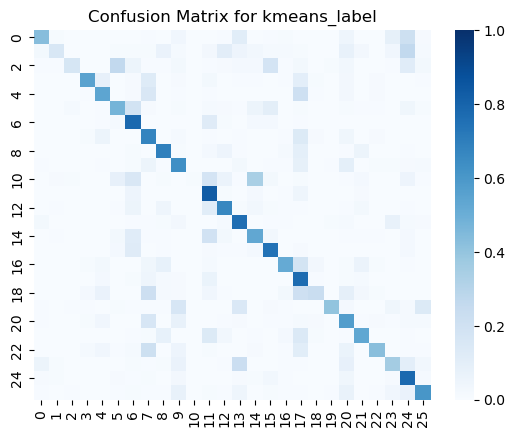

In [5]:
classifier.evaluate_model('kmeans_label')

In [6]:
model = classifier.train_model('gnn_kmeans_label')

Using the existing vectorized train set
Training model...
Model trained


Using existing vectorized test set
Making predictions...
              precision    recall  f1-score   support

           0       0.72      0.83      0.77     80138
           1       0.44      0.04      0.07      2919
           2       0.61      0.86      0.71     44484
           3       0.36      0.38      0.37      7563
           4       0.43      0.49      0.46      5437
           5       0.55      0.23      0.33      5557
           6       0.66      0.30      0.41      1073
           7       0.54      0.65      0.59      4088
           8       0.58      0.72      0.64      7551
           9       0.60      0.06      0.10      4245
          10       0.61      0.19      0.29      4276
          11       0.57      0.64      0.60     37725
          12       0.51      0.56      0.54      3598
          13       0.55      0.31      0.40      9347
          14       0.46      0.80      0.58      5609
          15       0.54      0.54      0.54      3344
          16       0.57 

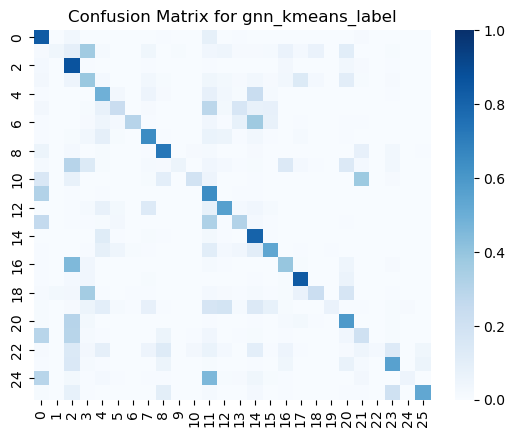

In [7]:
classifier.evaluate_model('gnn_kmeans_label')

# One-vs-rest clasiification

In [8]:
classifier.one_vs_rest(model)

Using existing dataset
Processing Fold 1/10
Fitting and applying TF-IDF on the train set...
Fitting TF-IDF finished
Applying TF-IDF on the test set...
Applying TF-IDF finished
Processing Periodical2Vec+$k$-means
Processing Periodical2Vec+Sperical $k$-means
Processing Periodical2Vec+movMF
Processing BERT+$k$-means
Processing Node2Vec+$k$-means
Processing Citation Matrix+$k$-means
Processing GNN+$k$-means
Processing Scopus
Processing Fold 2/10
Fitting and applying TF-IDF on the train set...
Fitting TF-IDF finished
Applying TF-IDF on the test set...
Applying TF-IDF finished
Processing Periodical2Vec+$k$-means
Processing Periodical2Vec+Sperical $k$-means
Processing Periodical2Vec+movMF
Processing BERT+$k$-means
Processing Node2Vec+$k$-means
Processing Citation Matrix+$k$-means
Processing GNN+$k$-means
Processing Scopus
Processing Fold 3/10
Fitting and applying TF-IDF on the train set...
Fitting TF-IDF finished
Applying TF-IDF on the test set...
Applying TF-IDF finished
Processing Periodica

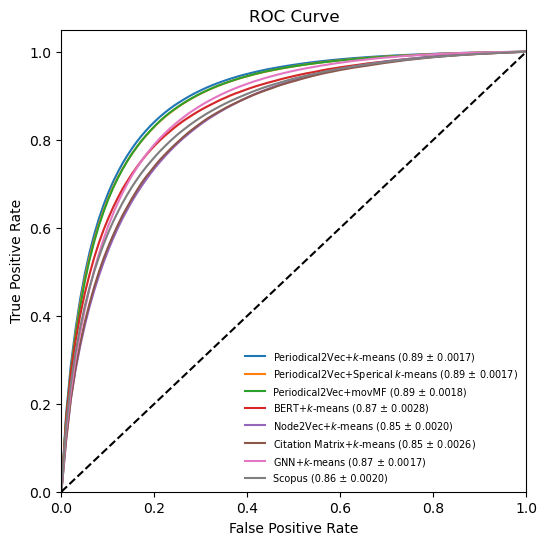

In [9]:
from scipy.stats import sem, t
# 汇总每个标签的结果并绘制 ROC 曲线
plt.figure(figsize=(6, 6))

for label_column, method_name in classifier.label_to_method.items():
    fpr_list = [result[0] for result in classifier.roc_results[label_column]]
    tpr_list = [result[1] for result in classifier.roc_results[label_column]]
    auc_list = [result[2] for result in classifier.roc_results[label_column]]
    
    # 计算平均曲线
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)], axis=0)
    
    # 计算置信区间
    confidence = 0.95
    t_value = t.ppf((1 + confidence) / 2, df=classifier.n_splits - 1)  # t 分布
    std_error = sem([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)], axis=0)
    ci = t_value * std_error  # 置信区间
    
    mean_auc = np.mean(auc_list)
    std_auc = np.std(auc_list)
    
    # 绘制 ROC 曲线
    plt.plot(
        mean_fpr, mean_tpr,
        label=f'{method_name} ({mean_auc:.2f} ± {std_auc:.4f})'
    )
    plt.fill_between(mean_fpr,
                     mean_tpr - ci,
                     mean_tpr + ci,
                     alpha=0.2,)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", fontsize=7, frameon=False)
plt.show()